# MLP Benchmark for IMU Gestures
Train and benchmark small MLP classifiers for IMU gesture recognition, balancing accuracy against model size and compute cost.


In [2]:
from pathlib import Path
import os.path
import subprocess
import tempfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm as progress_bar

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    f1_score, accuracy_score, balanced_accuracy_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

import emlearn
from emlearn import common as em_common
from emlearn.evaluate import size as em_size



In [3]:
def find_data_root() -> Path:
    here = Path.cwd()
    candidates = [
        here / "home-made" / "data",
        here / "data",
        here.parent / "data",
    ]
    for candidate in candidates:
        if candidate.is_dir():
            return candidate
    tried = ", ".join(str(c) for c in candidates)
    raise FileNotFoundError(f"Could not find data directory. Tried: {tried}")

DATA_ROOT = find_data_root()

def load_dataset(data_dir: Path):
    # Load all CSVs in data_dir; label is derived from filename stem.
    frames = []
    for csv_path in sorted(data_dir.glob("*.csv")):
        label = csv_path.stem  # filename (without extension) is the label
        df = pd.read_csv(csv_path)
        df["label"] = label
        frames.append(df)
    if not frames:
        raise FileNotFoundError(f"No CSV files found in {data_dir}")
    combined = pd.concat(frames, ignore_index=True)
    y = combined.pop("label")
    X = combined
    return X, y

X_all, y_all = load_dataset(DATA_ROOT)

# Keep backward-compatible names for downstream visualization cells
X_train = X_all
y_train = y_all

feature_names = X_all.columns.tolist()
class_names = sorted(y_all.unique())

print(f"Using data root: {DATA_ROOT}")
print(f"Loaded {X_all.shape[0]} samples with {len(class_names)} classes.")
print(f"Features per sample: {X_all.shape[1]}")
print("Classes:", class_names)



Using data root: /home/simong/workspace/EdgeSpell/home-made/data
Loaded 1845 samples with 6 classes.
Features per sample: 600
Classes: ['circle', 'downup', 'leftright', 'lightning', 'rightleft', 'updown']


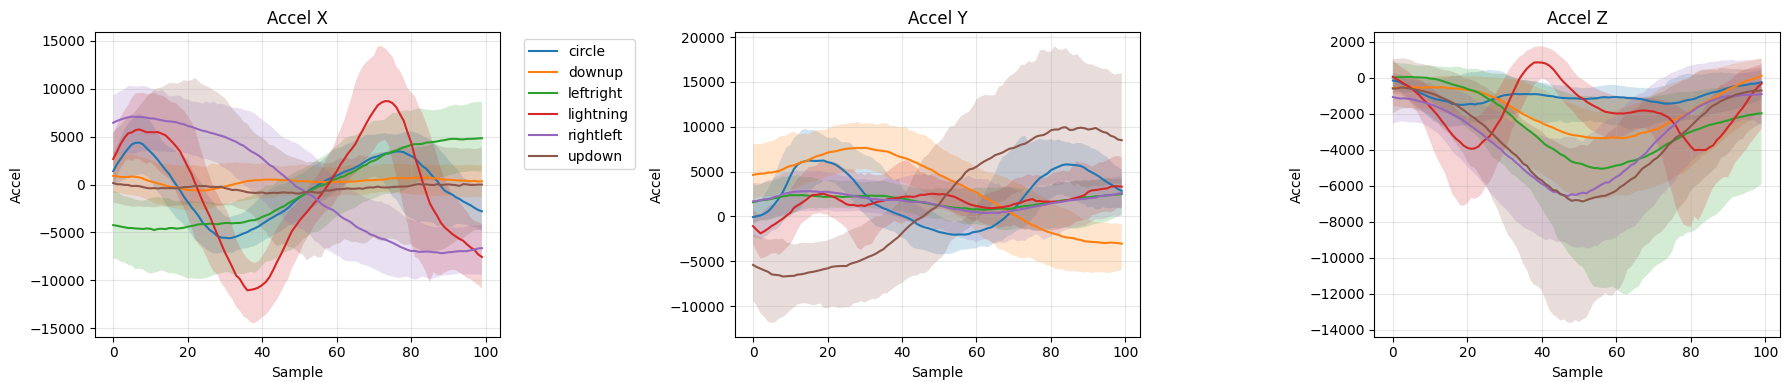

In [4]:
# Visualize acceleration profiles per class with 5th/95th percentile bands
ACCEL_AXES = ("X", "Y", "Z")

def accel_columns(axis: str):
    cols = [c for c in X_train.columns if c.endswith(f"Accel_{axis}")]
    cols.sort(key=lambda name: int(name.split("_")[0].replace("Sample", "")))
    return cols

sample_numbers = None
fig, axes = plt.subplots(1, len(ACCEL_AXES), figsize=(18, 4), sharey=False)
axes = np.atleast_1d(axes)

for ax_idx, axis in enumerate(ACCEL_AXES):
    cols = accel_columns(axis)
    sample_numbers = np.arange(len(cols))
    for cls in class_names:
        cls_rows = X_train[y_train == cls][cols]
        median = cls_rows.median(axis=0)
        low = cls_rows.quantile(0.05, axis=0)
        high = cls_rows.quantile(0.95, axis=0)
        axes[ax_idx].plot(sample_numbers, median, label=cls)
        axes[ax_idx].fill_between(sample_numbers, low, high, alpha=0.2)
    axes[ax_idx].set_title(f"Accel {axis}")
    axes[ax_idx].set_xlabel("Sample")
    axes[ax_idx].set_ylabel("Accel")
    axes[ax_idx].grid(True, alpha=0.3)

axes[0].legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()



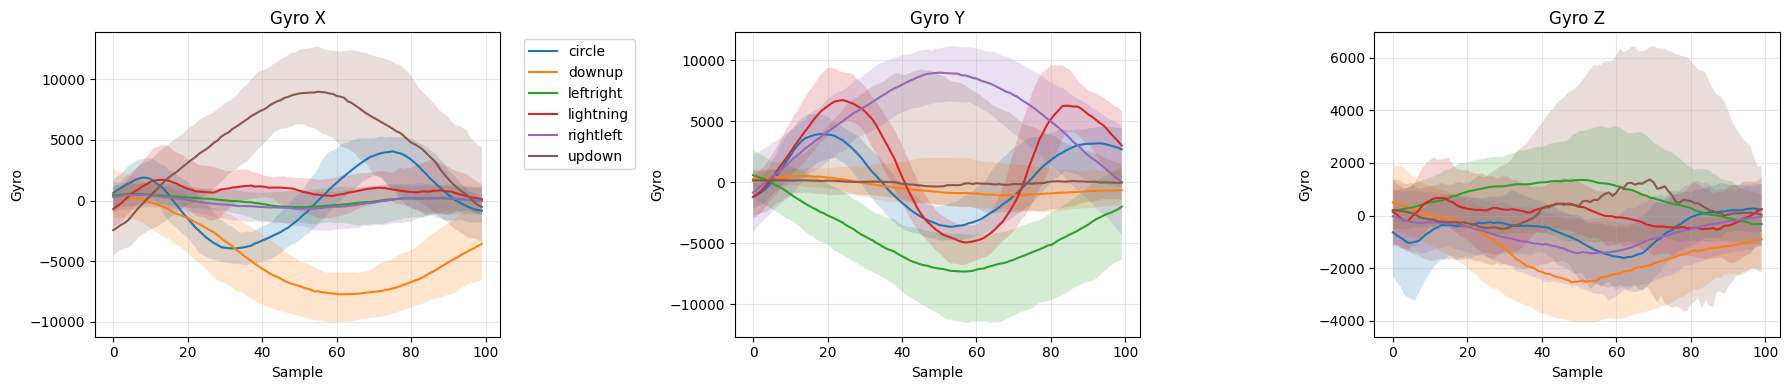

In [5]:
# Visualize gyro profiles per class with 5th/95th percentile bands
GYRO_AXES = ("X", "Y", "Z")

def gyro_columns(axis: str):
    cols = [c for c in X_train.columns if c.endswith(f"Gyro_{axis}")]
    cols.sort(key=lambda name: int(name.split("_")[0].replace("Sample", "")))
    return cols

sample_numbers = None
fig, axes = plt.subplots(1, len(GYRO_AXES), figsize=(18, 4), sharey=False)
axes = np.atleast_1d(axes)

for ax_idx, axis in enumerate(GYRO_AXES):
    cols = gyro_columns(axis)
    sample_numbers = np.arange(len(cols))
    for cls in class_names:
        cls_rows = X_train[y_train == cls][cols]
        median = cls_rows.median(axis=0)
        low = cls_rows.quantile(0.05, axis=0)
        high = cls_rows.quantile(0.95, axis=0)
        axes[ax_idx].plot(sample_numbers, median, label=cls)
        axes[ax_idx].fill_between(sample_numbers, low, high, alpha=0.2)
    axes[ax_idx].set_title(f"Gyro {axis}")
    axes[ax_idx].set_xlabel("Sample")
    axes[ax_idx].set_ylabel("Gyro")
    axes[ax_idx].grid(True, alpha=0.3)

axes[0].legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()



## MLP benchmark configuration
Hidden layer sizes control width/depth; alpha controls L2 regularization. Size/compute estimates are analytical (parameter count + MACs).


In [6]:
# Combine all IMU samples so each trial can draw fresh splits
all_features = X_all.copy()
all_labels = y_all.reset_index(drop=True)
label_to_int = {cls: idx for idx, cls in enumerate(class_names)}
all_labels_encoded = all_labels.map(label_to_int).astype(int)

# Hyperparameter grids for the MLP benchmark
HIDDEN_LAYER_GRID = [
    (8,),
    (16,),
    (32,),
    (64,),
    (16, 16),
    (32, 16),
    (32, 32),
]

ALPHA_GRID = [1e-5, 1e-4, 1e-3, 1e-2]

ACTIVATION = "relu"        # default activation to benchmark
MAX_ITER = 500
REPEATS_PER_MODEL = 10
TEST_FRACTION = 0.25

# Assume float32 weights/activations for size estimates
BYTES_PER_WEIGHT = 4
BYTES_PER_ACTIVATION = 4
TARGET_PLATFORM = 'arm'
TARGET_MCU = 'Cortex-M4F'
COMPILED_SIZE_SUPPORTED = True  # flip to False if a compile attempt fails



In [7]:
def count_mlp_params(mlp: MLPClassifier) -> int:
    # Return total number of trainable parameters (weights + biases).
    n_params = 0
    for W, b in zip(mlp.coefs_, mlp.intercepts_):
        n_params += W.size + b.size
    return int(n_params)

def estimate_mlp_macs(mlp: MLPClassifier, input_dim: int) -> int:
    # Rough estimate of MACs for one forward pass through the MLP.
    if isinstance(mlp.hidden_layer_sizes, int):
        hidden = [mlp.hidden_layer_sizes]
    else:
        hidden = list(mlp.hidden_layer_sizes)
    layer_sizes = [input_dim] + hidden + [mlp.n_outputs_]
    macs = 0
    for in_size, out_size in zip(layer_sizes[:-1], layer_sizes[1:]):
        macs += in_size * out_size
    return int(macs)

def estimate_mlp_size_bytes(mlp: MLPClassifier, input_dim: int) -> dict:
    # Analytical FLASH/RAM estimates based on parameter count and activations.
    n_params = count_mlp_params(mlp)
    flash_bytes = n_params * BYTES_PER_WEIGHT

    if isinstance(mlp.hidden_layer_sizes, int):
        hidden = [mlp.hidden_layer_sizes]
    else:
        hidden = list(mlp.hidden_layer_sizes)
    layer_sizes = [input_dim] + hidden + [mlp.n_outputs_]
    max_activations = max(layer_sizes)
    ram_bytes = 2 * max_activations * BYTES_PER_ACTIVATION

    return {
        "flash_bytes": int(flash_bytes),
        "ram_bytes": int(ram_bytes),
        "note": "Analytical estimate; not compiled C size.",
    }

def estimate_mlp_program_size(mlp: MLPClassifier, input_dim: int, platform: str = TARGET_PLATFORM, mcu: str = TARGET_MCU):
    "Attempt to compile the MLP using emlearn for a concrete FLASH/RAM estimate."
    global COMPILED_SIZE_SUPPORTED
    if not COMPILED_SIZE_SUPPORTED:
        return {'flash': None, 'ram': None, 'note': 'Compiled size skipped (previous compile failed; likely needs libm).'}

    try:
        cmodel = emlearn.convert(mlp, method='inline')
        c_code = cmodel.save(name='mlp_model')
        dtype = getattr(cmodel, 'dtype', 'float')
        include_dir = em_common.get_include_dir()
        arm_cflags = em_size.ARM_CORTEX_CFLAGS.get(mcu, '')

        with tempfile.TemporaryDirectory() as temp_dir:
            workdir = Path(temp_dir)
            code_path = workdir / 'prog.c'
            code_path.write_text(f"""
#include <math.h>
#pragma GCC diagnostic push
#pragma GCC diagnostic ignored "-Wunused-parameter"
{c_code}
#pragma GCC diagnostic pop
int main(void) {{
    {dtype} features[{input_dim}] = {{0}};
    return mlp_model_predict(features, {input_dim});
}}
""")

            compile_cmd = [
                'arm-none-eabi-gcc', '-Os', '-ffunction-sections', '-fdata-sections', '-Wall', '-Wextra', '-Wno-unused-parameter',
                *arm_cflags.split(), f'-I{include_dir}', '-c', 'prog.c', '-o', 'prog.o'
            ]
            link_cmd = [
                'arm-none-eabi-gcc', '-Os', '-ffunction-sections', '-fdata-sections', '-Wall', '-Wextra', '-Wno-unused-parameter',
                *arm_cflags.split(), '-Wl,--gc-sections', '-specs=nosys.specs', 'prog.o', '-lm', '-o', 'out.elf'
            ]

            subprocess.run(compile_cmd, cwd=workdir, check=True, capture_output=True)
            subprocess.run(link_cmd, cwd=workdir, check=True, capture_output=True)
            sizes = em_size.run_binutils_size(workdir / 'out.elf', binary='arm-none-eabi-size')
            return {
                'flash': sizes['flash'],
                'ram': sizes['ram'],
                'note': 'Compiled with -lm for math ops',
            }
    except Exception as exc:
        COMPILED_SIZE_SUPPORTED = False
        return {'flash': None, 'ram': None, 'note': f'Compiled size failed: {exc}'}



In [8]:
def benchmark_config(params, repeats=REPEATS_PER_MODEL, test_size=TEST_FRACTION):
    trials = []
    size_info_analytic = None
    size_info_compiled = {'flash': None, 'ram': None, 'note': 'Not attempted'}

    for seed in range(repeats):
        X_tr, X_va, y_tr, y_va = train_test_split(
            all_features, all_labels_encoded,
            test_size=test_size,
            random_state=seed,
            stratify=all_labels_encoded,
        )

        # Scale features (critical for MLP)
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)
        X_va_scaled = scaler.transform(X_va)

        clf = MLPClassifier(
            hidden_layer_sizes=params["hidden_layer_sizes"],
            alpha=params["alpha"],
            activation=ACTIVATION,
            max_iter=MAX_ITER,
            early_stopping=True,
            n_iter_no_change=20,
            random_state=seed,
        )

        clf.fit(X_tr_scaled, y_tr)
        y_pred = clf.predict(X_va_scaled)

        acc = accuracy_score(y_va, y_pred)
        bal_acc = balanced_accuracy_score(y_va, y_pred)

        input_dim = X_tr_scaled.shape[1]
        macs = estimate_mlp_macs(clf, input_dim=input_dim)
        size_analytic = estimate_mlp_size_bytes(clf, input_dim=input_dim)

        if size_info_analytic is None:
            size_info_analytic = size_analytic
            size_info_compiled = estimate_mlp_program_size(clf, input_dim=input_dim, platform=TARGET_PLATFORM, mcu=TARGET_MCU)

        trials.append({
            "seed": seed,
            "hidden_layer_sizes": params["hidden_layer_sizes"],
            "alpha": params["alpha"],
            "accuracy": acc,
            "balanced_accuracy": bal_acc,
            "compute_macs": macs,
            "flash_bytes": size_info_analytic["flash_bytes"],
            "ram_bytes": size_info_analytic["ram_bytes"],
            "size_note": size_info_analytic["note"],
            "flash_bytes_compiled": size_info_compiled.get('flash') if size_info_compiled else None,
            "ram_bytes_compiled": size_info_compiled.get('ram') if size_info_compiled else None,
            "compiled_note": size_info_compiled.get('note') if size_info_compiled else None,
        })

    df = pd.DataFrame(trials)
    summary = {
        "param_hidden_layer_sizes": params["hidden_layer_sizes"],
        "param_alpha": params["alpha"],
        "trials": len(df),
        "mean_test_accuracy": df["accuracy"].mean(),
        "mean_balanced_accuracy": df["balanced_accuracy"].mean(),
        "mean_test_compute_macs": df["compute_macs"].mean(),
        "flash_bytes": size_info_analytic["flash_bytes"],
        "ram_bytes": size_info_analytic["ram_bytes"],
        "size_note": size_info_analytic["note"],
        "flash_bytes_compiled": size_info_compiled.get('flash') if size_info_compiled else None,
        "ram_bytes_compiled": size_info_compiled.get('ram') if size_info_compiled else None,
        "compiled_note": size_info_compiled.get('note') if size_info_compiled else None,
    }
    return df, summary



In [9]:
mlp_bench_trials = []
mlp_bench_summaries = []

for hidden in progress_bar(HIDDEN_LAYER_GRID, desc="hidden_layer_sizes"):
    for alpha in progress_bar(ALPHA_GRID, desc="alpha", leave=False):
        cfg = {
            "hidden_layer_sizes": hidden,
            "alpha": alpha,
        }
        trial_df, summary = benchmark_config(cfg)
        mlp_bench_trials.append(trial_df)
        mlp_bench_summaries.append(summary)

mlp_bench_trials = pd.concat(mlp_bench_trials, ignore_index=True)
mlp_bench_summary = pd.DataFrame(mlp_bench_summaries)

print("Top 5 by mean balanced accuracy")
display(
    mlp_bench_summary
    .sort_values("mean_balanced_accuracy", ascending=False)
    .head()
)
mlp_bench_summary.head()



hidden_layer_sizes:   0%|          | 0/7 [00:00<?, ?it/s]

hidden_layer_sizes: 100%|██████████| 7/7 [03:25<00:00, 29.42s/it]

Top 5 by mean balanced accuracy


,param_hidden_layer_sizes,param_alpha,trials,mean_test_accuracy,mean_balanced_accuracy,mean_test_compute_macs,flash_bytes,ram_bytes,size_note,flash_bytes_compiled,ram_bytes_compiled,compiled_note
27,"(32, 32)",0.01000,10,0.998052,0.998037,20416.0,81944,4800,Analytical estimate; not compiled C size.,86984,5924,Compiled with -lm for math ops
26,"(32, 32)",0.00100,10,0.998052,0.998037,20416.0,81944,4800,Analytical estimate; not compiled C size.,86984,5924,Compiled with -lm for math ops
25,"(32, 32)",0.00010,10,0.998052,0.998037,20416.0,81944,4800,Analytical estimate; not compiled C size.,86984,5924,Compiled with -lm for math ops
24,"(32, 32)",0.00001,10,0.998052,0.998037,20416.0,81944,4800,Analytical estimate; not compiled C size.,86984,5924,Compiled with -lm for math ops
8,"(32,)",0.00001,10,0.997619,0.997662,19392.0,77720,4800,Analytical estimate; not compiled C size.,82740,5924,Compiled with -lm for math ops


,param_hidden_layer_sizes,param_alpha,trials,mean_test_accuracy,mean_balanced_accuracy,mean_test_compute_macs,flash_bytes,ram_bytes,size_note,flash_bytes_compiled,ram_bytes_compiled,compiled_note
0,"(8,)",0.00001,10,0.989394,0.989182,4848.0,19448,4800,Analytical estimate; not compiled C size.,24468,5924,Compiled with -lm for math ops
1,"(8,)",0.00010,10,0.989394,0.989182,4848.0,19448,4800,Analytical estimate; not compiled C size.,24468,5924,Compiled with -lm for math ops
2,"(8,)",0.00100,10,0.989394,0.989182,4848.0,19448,4800,Analytical estimate; not compiled C size.,24468,5924,Compiled with -lm for math ops
3,"(8,)",0.01000,10,0.989394,0.989182,4848.0,19448,4800,Analytical estimate; not compiled C size.,24468,5924,Compiled with -lm for math ops
4,"(16,)",0.00001,10,0.996753,0.996782,9696.0,38872,4800,Analytical estimate; not compiled C size.,43892,5924,Compiled with -lm for math ops


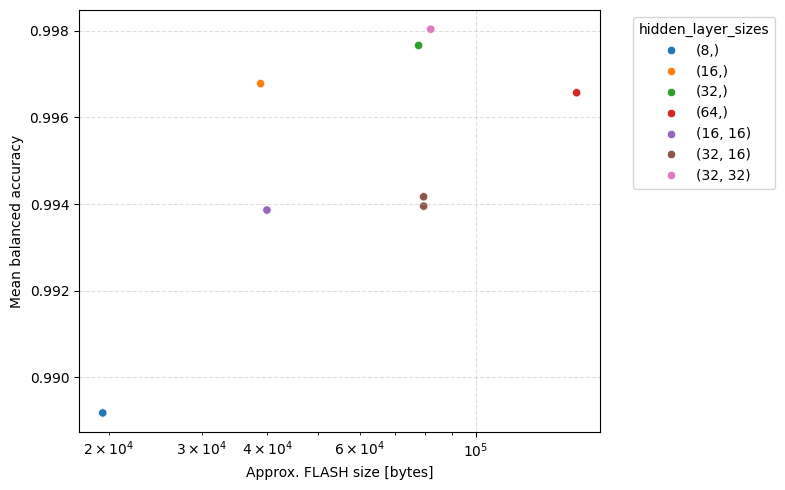

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(
    data=mlp_bench_summary,
    x="flash_bytes",
    y="mean_balanced_accuracy",
    hue=mlp_bench_summary["param_hidden_layer_sizes"].astype(str),
    ax=ax,
)
ax.set_xscale("log")
ax.set_xlabel("Approx. FLASH size [bytes]")
ax.set_ylabel("Mean balanced accuracy")
ax.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="hidden_layer_sizes", bbox_to_anchor=(1.05, 1), loc="upper left")
fig.tight_layout()



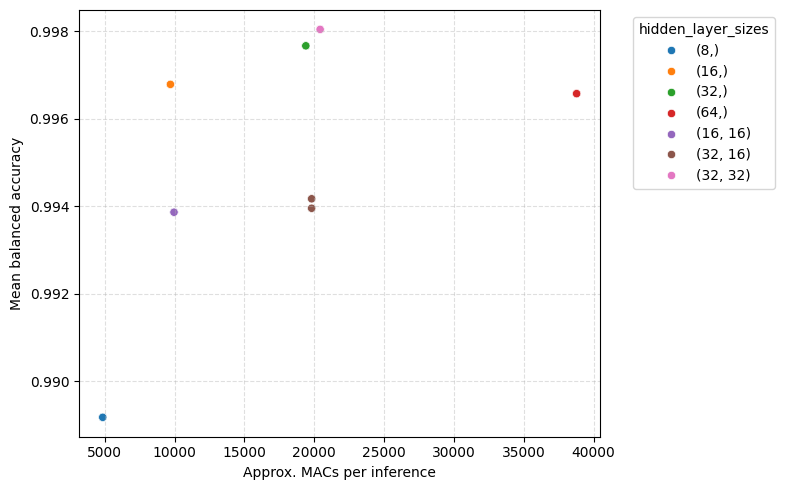

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(
    data=mlp_bench_summary,
    x="mean_test_compute_macs",
    y="mean_balanced_accuracy",
    hue=mlp_bench_summary["param_hidden_layer_sizes"].astype(str),
    ax=ax,
)
ax.set_xlabel("Approx. MACs per inference")
ax.set_ylabel("Mean balanced accuracy")
ax.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="hidden_layer_sizes", bbox_to_anchor=(1.05, 1), loc="upper left")
fig.tight_layout()



Models are ranked by accuracy; architecture width/depth drives both accuracy and size. Alpha is a regularizer affecting generalization but not size. Size/compute are analytical and do not reflect compiled emlearn C artifacts.



## Model selection and export
Pick best MLPs by weighted accuracy vs. compute/size, export C, and inspect confusion matrices on a held-out split.


In [16]:

import re

BUILDS_DIR = Path("builds")
BUILDS_DIR.mkdir(exist_ok=True)


def _normalize(series):
    s = series.astype(float).fillna(series.max())
    denom = s.max() - s.min()
    return (s - s.min()) / denom if denom else s * 0


def _clean_c_identifier(name: str) -> str:
    cleaned = re.sub(r'[^0-9a-zA-Z_]', '_', name)
    if not cleaned or (not cleaned[0].isalpha() and cleaned[0] != '_'):
        cleaned = f"m_{cleaned}"
    return cleaned


COMPUTE_COL = 'mean_test_compute_macs'


def pick_by_weights(df, w_bal_acc=1.0, w_compute=0.0, w_flash=0.0, compute_col=COMPUTE_COL):
    work = df.copy()
    work['score'] = (
        w_bal_acc * work['mean_balanced_accuracy']
        - w_compute * _normalize(work[compute_col])
        - w_flash * _normalize(work['flash_bytes'])
    )
    return work.sort_values('score', ascending=False).iloc[0]


# Shared evaluation split for confusion matrices
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    all_features, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)


def train_and_export_mlp(params, name_prefix, out_dir=BUILDS_DIR):
    hidden = params['param_hidden_layer_sizes']
    alpha = params['param_alpha']
    base_name = f"{name_prefix}_{hidden}_{alpha}".replace(' ', '')
    c_name = _clean_c_identifier(base_name)

    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_train_sel)
    X_te_scaled = scaler.transform(X_test_sel)

    clf = MLPClassifier(
        hidden_layer_sizes=hidden,
        alpha=alpha,
        activation=ACTIVATION,
        max_iter=MAX_ITER,
        early_stopping=True,
        n_iter_no_change=20,
        random_state=0,
    )
    clf.fit(X_tr_scaled, y_train_enc)

    cmodel = emlearn.convert(clf, method='inline')
    c_code = cmodel.save(name=c_name)
    out_path = out_dir / f"{c_name}.c"
    out_path.write_text(c_code)

    return out_path, clf, scaler, X_test_sel.copy(), y_test_sel.copy()


y_train_enc = y_train_sel.map(label_to_int).astype(int)
y_test_enc = y_test_sel.map(label_to_int).astype(int)

# Method 1: weighted blend of balanced accuracy (higher) vs compute/flash (lower)
weights = dict(w_bal_acc=1.0, w_compute=0.3, w_flash=0.1)
best_weighted = pick_by_weights(mlp_bench_summary, **weights)
wt_path, wt_clf, wt_scaler, wt_Xte, wt_yte = train_and_export_mlp(best_weighted, name_prefix="mlp_wt")
print("Weighted best:")
print(best_weighted[[
    'param_hidden_layer_sizes','param_alpha','mean_balanced_accuracy',
    'mean_test_compute_macs','flash_bytes','ram_bytes',
    'flash_bytes_compiled','ram_bytes_compiled','compiled_note'
]])
print("C export:", wt_path)

# Method 2: prioritize accuracy, smallest memory under compute budget
compute_budget = mlp_bench_summary[COMPUTE_COL].median() * 1.2
filtered = mlp_bench_summary[
    (mlp_bench_summary[COMPUTE_COL] <= compute_budget)
].dropna(subset=['flash_bytes','ram_bytes'])
if not filtered.empty:
    best_perf = filtered.sort_values(
        ['mean_balanced_accuracy', 'flash_bytes', 'ram_bytes'],
        ascending=[False, True, True]
    ).iloc[0]
    perf_path, perf_clf, perf_scaler, perf_Xte, perf_yte = train_and_export_mlp(best_perf, name_prefix="mlp_perf")
    print(f"Budgeted best (compute <= {compute_budget:.1f} MACs):")
    print(best_perf[[
        'param_hidden_layer_sizes','param_alpha','mean_balanced_accuracy',
        'mean_test_compute_macs','flash_bytes','ram_bytes',
        'flash_bytes_compiled','ram_bytes_compiled','compiled_note'
    ]])
    print("C export:", perf_path)
else:
    best_perf = None
    perf_path = perf_clf = perf_scaler = perf_Xte = perf_yte = None
    print(f"No models meet compute budget <= {compute_budget:.1f}")



Weighted best:
param_hidden_layer_sizes                              (8,)
param_alpha                                        0.00001
mean_balanced_accuracy                            0.989182
mean_test_compute_macs                              4848.0
flash_bytes                                          19448
ram_bytes                                             4800
flash_bytes_compiled                                 24468
ram_bytes_compiled                                    5924
compiled_note               Compiled with -lm for math ops
Name: 0, dtype: object
C export: builds/mlp_wt__8___1e_05.c
Budgeted best (compute <= 23270.4 MACs):
param_hidden_layer_sizes                          (32, 32)
param_alpha                                        0.00001
mean_balanced_accuracy                            0.998037
mean_test_compute_macs                             20416.0
flash_bytes                                          81944
ram_bytes                                             4800

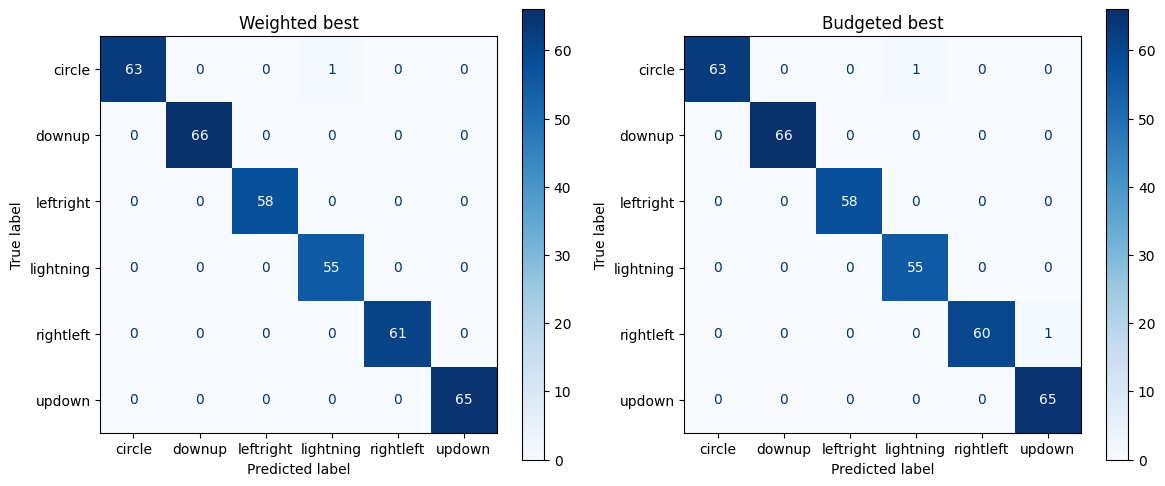

In [17]:
# Confusion matrices for the exported models

def plot_confusion(ax, clf, scaler, X_test, y_test, title):
    y_pred = clf.predict(scaler.transform(X_test))
    y_pred_labels = [class_names[int(i)] for i in y_pred]
    arr_true = np.array(y_test)
    if np.issubdtype(arr_true.dtype, np.integer):
        y_true = [class_names[int(i)] for i in y_test]
    else:
        y_true = list(y_test)
    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred_labels,
        labels=class_names,
        normalize=None,
        cmap='Blues',
        ax=ax,
    )
    ax.set_title(title)

axes_needed = 2 if best_perf is not None else 1
fig, axes = plt.subplots(1, axes_needed, figsize=(12, 5))
axes = np.atleast_1d(axes)
plot_confusion(axes[0], wt_clf, wt_scaler, wt_Xte, wt_yte, "Weighted best")
if best_perf is not None:
    plot_confusion(axes[1], perf_clf, perf_scaler, perf_Xte, perf_yte, "Budgeted best")
fig.tight_layout()


